## Example of Trans-C sampling across independent model states: Regression

This notebook demonstrates Bayesian sampling of a linear polynomial regression problem
using the Product-space sampler.

In [1]:
# general python utility packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
from tqdm import tqdm
import corner
import time
from collections import Counter
from matplotlib.ticker import MaxNLocator
import pickle as pickle
from scipy.optimize import minimize

#### TransC class

In [2]:
from pytransc import TransC_Sampler

In [3]:
def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return np.array(flat_list)

In [4]:
def solveLS(d,G,Cdinv,mu=None,Cmpriorinv=None): # Least squares solver
    A = np.dot(np.transpose(G), Cdinv) # Find solution
    GtG = np.dot(A, G) # G^T C_inv G^T
    if(Cmpriorinv is not None) and (mu is not None): GtG += Cmpriorinv
    GtGinv = np.linalg.inv(GtG) # Inverse of G^TC_inv G
    B = np.dot(A,d)
    if(Cmpriorinv is not None) and (mu is not None): B += np.dot(Cmpriorinv,mu)
    mls = np.dot(GtGinv, B)
    return mls, GtGinv

In [5]:
def calcE(dp,dobs,Cdinv,Cmpost,m,muprior,Cmpriorinv):
    misfit = 0.5*(np.dot((dobs-dp),np.dot(Cdinv,(dobs-dp))))
    misfit += 0.5*(np.dot((muprior-m),np.dot(Cmpriorinv,(muprior-m))))
    f = np.sqrt(2*np.pi)**len(dp)
    detCdinv = np.linalg.det(Cdinv)
    detCmpost = np.linalg.det(Cmpost)
    detCmpriorinv = np.linalg.det(Cmpriorinv)
    E = np.sqrt(detCmpost*detCdinv*detCmpriorinv)*np.exp(-misfit)/f
    return E

--------

## Polynomial regression theory

Here we set up a problem of polynomial regression fitting a set of x,y data with up to a 4th order polynomial.

To begin with, we will work with polynomial curves, $$y(x) = \sum_{n=0}^N m_n x^n\,.$$
Here, $N$ is the 'order' of the polynomial: if $N=1$ we have a straight line, if $N=2$ it will be a quadratic, and so on. The $m_n$ are the 'model coefficients'.

To compute $y(x)$ for multiple $x$-values simultaneously, we  write $$ \left(\begin{array}{c}y_1\\y_2\\\vdots\\y_N\end{array}\right) = \left(\begin{array}{ccc}1&x_1&x_1^2\\1&x_2&x_2^2\\\vdots&\vdots&\vdots\\1&x_N&x_N^2\end{array}\right)\left(\begin{array}{c}m_0\\m_1\\m_2\end{array}\right)$$This has the general form, $\mathbf{d=Gm}$, and so the best-fitting model can be identified using a least-squares algorithm.

The maximum Likelihood solution for this problem is the model which minimizes

$$
\phi(\mathbf{m}) = \frac{1}{2} (\mathbf{d-Gm})^TC_D^{-1} (\mathbf{d-Gm}),
$$
which leads to

$$
{\bf m}_{LS} = \left(\mathbf{G}^T C_D^{-1} \mathbf{G}\right)^{-1}\mathbf{G}^T  C_D^{-1} \mathbf{d}.
$$

The *MAP* model, $\hat{{\bf m}}$, for this problem minimizes of the sum of the negative log-Likelihood and log-Gaussian prior 

$$
\phi(\mathbf{m}) = \frac{1}{2} (\mathbf{d-Gm})^TC_D^{-1} (\mathbf{d-Gm}) + \frac{1}{2} (\mathbf{m - m_o})^TC_M^{-1} (\mathbf{m - m_o})
$$

which leads to

$$
\hat{{\bf m}} = \left(\mathbf{G}^T C_D^{-1} \mathbf{G} + C_M^{-1}\right)^{-1}(\mathbf{G}^T  C_D^{-1} \mathbf{d} + C_M^{-1}\mathbf{m_o}).
$$

For Gaussian Likelihood and prior the evidence is a known analytical expression.

$$
p{(\bf d}) = \frac{e^{-\phi(\hat{{\bf m}})}}{(2\pi)^{N/2}} \left[ \frac{|\hat{C}_M|}{|C_D||C_M|}\right]^{1/2}.
$$
where $\hat{C}_M$ is the posterior model covariance, 

$$
\hat{C}_M = \left(\mathbf{G}^T C_D^{-1} \mathbf{G} + C_M^{-1}\right)^{-1}
$$

In [6]:
def getG(x,order): # build design matrix, G for polynomial data fitting, at data points x up to order order
    return np.transpose([x**(i) for i in range(order+1)])

We generate some random samples from $y=3x/5+0.3$, add Gaussian random noise to them.

In [7]:
np.random.seed(61254557)
ndata,sigma = 20,0.2
xobs = np.sort(np.random.rand(ndata)) # x values of data
mtrue = np.array([0.3,0.6])
G = getG(xobs,1)
dobs = np.dot(G,mtrue) + np.random.normal(0,sigma,size=len(xobs))
Cdinv = np.eye(ndata)/(sigma**2)

Set up prior for Evidence calculation.

In [8]:
mls, Cmpost, G, Ev, maxorder = [],[], [], [], 3
Cmprior = [20*np.eye(i+1) for i in np.arange(maxorder+1)]
Cmpriorinv = [0.05*np.eye(i+1) for i in np.arange(maxorder+1)]
muprior = [np.zeros(i+1) for i in np.arange(maxorder+1)]

Solve least squares solution and calculate evidence for each model.

In [9]:
for i in range(maxorder+1):
    Gp = getG(xobs,i)
    solp, Cmp = solveLS(dobs,Gp,Cdinv) # Maximum Likelihood solution
    dpred = np.dot(Gp,solp)
    mls.append(solp)
    Cmpost.append(Cmp)
    G.append(Gp)
    solp2, Cmp2 = solveLS(dobs,Gp,Cdinv,mu=muprior[i],Cmpriorinv=Cmpriorinv[i]) # MAP model and model covariance with Gaussian prior
    Ev.append(calcE(dpred,dobs,Cdinv,Cmp2,solp2,muprior[i],Cmpriorinv[i]))  # Analytical evidence calculation
Ev/=np.sum(Ev)

Plot solutions.

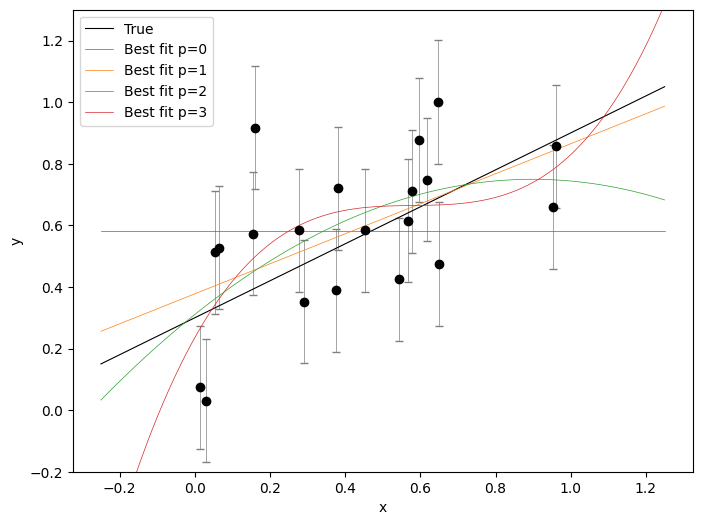

In [10]:
xplot = np.linspace(-0.25,1.25,100)
Gplot = getG(xplot,1)
dplot = np.dot(Gplot,mtrue)
#
plt.figure(figsize=(8,6))
plt.errorbar(xobs, dobs, yerr=sigma, capsize=3, fmt='ko', ecolor = "grey",lw=0.5)
plt.plot(xplot,dplot,label='True',color='k',lw=0.8)
for i in range(maxorder+1):
    Gplotp = getG(xplot,i)
    dpred = np.dot(Gplotp,mls[i])
    plt.plot(xplot,dpred,label='Best fit p='+str(i),lw=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-0.2,1.3)
plt.legend()
plt.show()

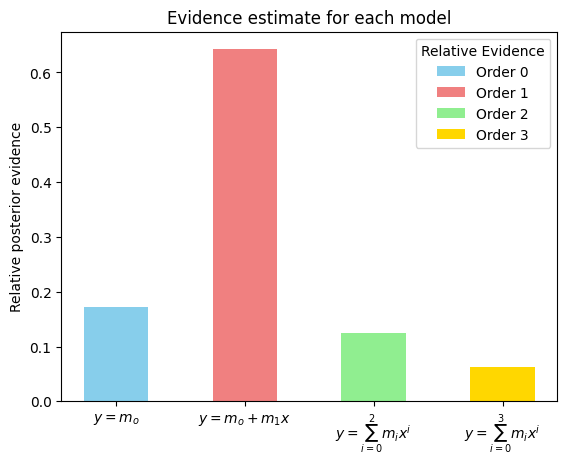

In [11]:
# plot evidence values

fig, ax = plt.subplots()

fruits = [r'$y=m_o$', r'$y=m_o + m_1x$', r'$y = \sum_{i=0}^2 m_ix^i$', r'$y = \sum_{i=0}^3 m_ix^i$']
counts = [Ev[i] for i in range(maxorder+1)]
bar_labels = ['Order 0','Order 1', 'Order 2', 'Order 3'] # Define a list of labels, one for each bar

bar_colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold'] # Define a list of colors, one for each bar

ax.bar(fruits, counts, label=bar_labels, width=0.5,color=bar_colors)

ax.set_ylabel('Relative posterior evidence')
ax.set_title('Evidence estimate for each model')
ax.legend(title='Relative Evidence')

plt.show()

In [12]:
Ev

array([0.17163235, 0.64217786, 0.12414475, 0.06204504])

----------------

Set some global control parameters.

In [13]:
plotting = True      # Create some diagnostic displays of outputs
parallel = False     # Use parallel computation for sampling

### Log-posterior Likeihood, prior and PDF for each state

In [14]:
def log_Likelihood(x,state,dobs,G,Cdinv):
    dpred = np.dot(G[state],x)
    misfit = 0.5*(np.dot((dobs-dpred),np.dot(Cdinv,(dobs-dpred))))
    f = np.sqrt(2*np.pi)**len(dpred)
    detCdinv = np.linalg.det(Cdinv)
    logL = -np.log(f) -misfit + np.log(detCdinv)
    return logL

In [15]:
def log_prior(x,state,muprior,Cmprior):
    mu = muprior[state]
    cov = Cmprior[state]
    rv = stats.multivariate_normal(mean=mu,cov=cov) # instance of multi-dimensional Gaussian
    return rv.logpdf(x)

In [16]:
def log_posterior(x,state,dobs,G, Cdinv, muprior, Cmprior): # Multi-state log Posterior PDF evaluation (unormalised)
    return log_Likelihood(x,state,dobs,G,Cdinv) + log_prior(x,state,muprior,Cmprior)
log_posterior_args = [dobs,G,Cdinv,muprior,Cmprior]

### Starting points for MCMC samplers in each state

In [17]:
# first we optimize each state to find good starting point for all McMC samplers
np.random.seed(42)
nstates = maxorder+1               # Number of distinct states
ndims  = [1,2,3,4]                 # Number of model parameters in each stateif(True):
nll = lambda *args: -log_posterior(*args)
ml = []
print("Maximum likelihood estimates:")
for i in range(nstates):
    initial = 0.5*np.ones(i+1)
    soln = minimize(nll, initial, args=(i,dobs,G,Cdinv,muprior,Cmprior))
    ml.append(soln.x)
    print("x_ml ",soln.x)

Maximum likelihood estimates:
x_ml  [0.58148024]
x_ml  [0.37788932 0.48664354]
x_ml  [ 0.31354801  0.95796058 -0.52400541]
x_ml  [ 0.28548373  1.4395107  -1.83289387  0.89632873]


### Pseudo-prior for each state

Here we use a fixed Gaussian pseudo prior for each state, which can be difficult to decide in advance.

In [18]:
Cmpseudo = [20*np.eye(i+1) for i in np.arange(maxorder+1)]  # Covariances of pseudo priors
mupseudo = [np.zeros(i+1) for i in np.arange(maxorder+1)]
def log_pseudo_prior(x,state,mupseudo,Cmpseudo,returndeviate=False):               # multi-state log pseudo-prior density and deviate generator
    mu = mupseudo[state]                  # Gaussian mean for current state
    cov = Cmpseudo[state]            # covariance matrices for current state
    rv = stats.multivariate_normal(mean=mu,cov=cov) # instance of multi-dimensional Gaussian
    if(returndeviate):
        x = rv.rvs() # generate deviate of multi-dimensional Gaussian
        logppx = rv.logpdf(x) # log amplitude of multi-dimensional Gaussian
        if(type(x) != np.ndarray): x = np.array([x]) # deal with 1D case where rv returns a scalar
        return logppx,x
    else:
        return rv.logpdf(x) # log amplitude of multi-dimensional Gaussian 

log_pseudo_prior_args = [mupseudo,Cmpseudo]   # additional argument list beyond (x,state)    

Here we use an automatic pseudo prior for each state which corresponds to a best fit multi-dimensional Gaussian to posterior ensembles in each state.

This is built using the class function `TransC_Sampler.build_auto_pseudo_prior()` which returns a function which we'll call `log_pseudo_prior()`. 
This function can be called in two ways:

- Firstly, with the call sequence `logPDF = log_pseudo_prior(x,state)`, where it evaluates the normalised log pseudo prior for point `x` in state `state`;
- Secondly, with the call sequence `logPDF, deviate = TransC_Sampler.build_auto_pseudo_prior(NULL,state,returndeviate=True)`, where it generates a random deviate from the pseudo-prior and calculates its logPDF.

In [19]:
# This generates posterior samples in each state and fits a Gaussain to them to become the pseudo prior
nwalkers_auto = 32                                              # Number of walkers for auto pseudo prior fitting
nsteps_auto = 1000                                              # Number of chain steps for auto pseudo prior fitting
autothin = True                                                 # Thin internally generated within state posterior ensembles by their auto-correlation 
                                                                # (This can take additional compute time, and is not necessary if input ensembles are already independent.)
pos = []
for i in range(nstates): # generate starting points for each chain in each state
    pos.append(ml[i] + 1e-4 * np.random.randn(nwalkers_auto, ndims[i])) # add random perturbation to maximum Likelihood models
    
tcs = TransC_Sampler(nstates,ndims) # create instance of sampler
auto_log_pseudo_prior = tcs.build_auto_pseudo_prior(pos,log_posterior,
                                               log_posterior_args=log_posterior_args,
                                               nwalkers=nwalkers_auto,
                                               nsamples=nsteps_auto,
                                               autothin=autothin,
                                               parallel=parallel)

def log_pseudo_prior(x,state,returndeviate=False):               # multi-state log pseudo-prior density and deviate generator
    return auto_log_pseudo_prior(x,state,returndeviate=returndeviate)

## Trans-C samping across model states with the Product-Space sampler 

Here we demonstrate use of the *Product-Space sampler*.

Here we concatenate all model vectors to a single product space model vector and perform MCMC sampling in this larger fixed dimensional space.

In [20]:
# perform initiation of IS-sampler
tc = TransC_Sampler(nstates,ndims) # Create instances of states

In [21]:
# product space sampling set up
nwalkers_ps = 32                                              # Number of walkers
nsteps_ps = 100000                                            # Number of chain steps 
pos_states = np.random.choice(np.arange(nstates),nwalkers_ps) # Random initial states of each walker
pos = []
for i in range(nstates): # generate starting points for each chain in each state
    pos.append(ml[i] + 1e-4 * np.random.randn(nwalkers_ps, ndims[i])) # add random perturbation to maximum Likelihood models

In [22]:
start_time = time.time()
tc.run_product_space_sampler(nwalkers_ps,
                 nsteps_ps,
                 pos,
                 pos_states,
                 log_posterior,
                 log_pseudo_prior,
                 log_posterior_args=log_posterior_args,
                 parallel=parallel,
                 progress=True)
elapsed_time = time.time() - start_time


Running product space trans-C sampler

Number of walkers               :  32
Number of states being sampled  :  4
Dimensions of each state        :  [1, 2, 3, 4]


100%|████████████████████████████████████████████████████████████████████████████| 100000/100000 [20:56<00:00, 79.60it/s]


In [23]:
# print some diagnostics
print('\n Algorithm type                                      :', tc.alg)

#extract trans-C samples and chains
discard = 0                  # chain burnin
thin = 20                    # chain thinning
chain,states_chain = tc.get_visits_to_states(discard=discard,thin=thin,normalize=True,walker_average='mean',return_samples=True)
key = tc

print(' Average acceptance rate of all walkers              :',np.round(tc.acceptance_rate,2))
print(' Maximum auto correlation time of parameters         :',np.round(tc.max_autocorr_time,3))
print(' Average auto correlation time of parameters         :',np.round(tc.mean_autocorr_time,3))
print(' Auto correlation time of between state jumps        :',np.round(tc.autocorr_time_for_between_state_jumps,3))
print(' Total number of state changes for all walkers       :',tc.total_state_changes)
print(' Number of state changes for each walker             :\n',*tc.state_changes_perwalker)
print(' Average % acceptance rate for between state changes :',tc.acceptance_rate_between_states)
print(' Analytical relative marginal Likelihoods            :', *np.round(Ev,5))
print(' Estimated relative evidences                        :', *np.round((tc.relative_marginal_likelihoods),5))
print(' Elapsed time.                                       :', np.round(elapsed_time,2),'s \n')


 Algorithm type                                      : TransC-product-space
 Average acceptance rate of all walkers              : 37.8
 Maximum auto correlation time of parameters         : 172.533
 Average auto correlation time of parameters         : 157.07
 Auto correlation time of between state jumps        : 172.533
 Total number of state changes for all walkers       : 46557
 Number of state changes for each walker             :
 1439 1388 1471 1485 1441 1392 1422 1451 1494 1500 1481 1509 1427 1423 1538 1412 1436 1403 1416 1547 1519 1491 1374 1444 1461 1443 1468 1462 1424 1432 1473 1491
 Average % acceptance rate for between state changes : 29.098125
 Analytical relative marginal Likelihoods            : 0.17163 0.64218 0.12414 0.06205
 Estimated relative evidences                        : 0.17436 0.64339 0.12603 0.05621
 Elapsed time.                                       : 1256.34 s 



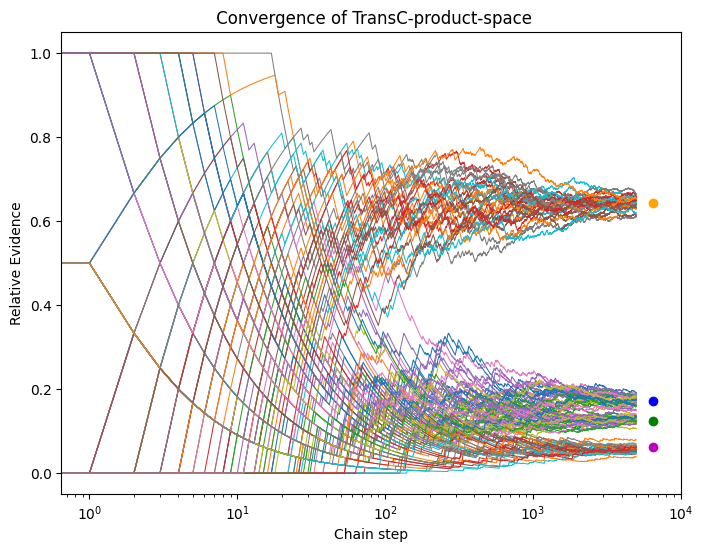

In [29]:
# plot relative number of visit to each state along the chain
if(plotting):
    fig, axes = plt.subplots(figsize=(8,6))
    if(chain.ndim == 3): # plot chains for each state and walker
        plt.semilogx(chain.reshape(np.shape(chain)[0],-1),lw=0.75)
    elif(chain.ndim==2): # plot chains for each state average over walkers
        plt.semilogx(chain.reshape(np.shape(chain)[0],-1),lw=0.75,label=['State 1','State 2','State 3'])
        plt.legend()
    plt.xlabel('Chain step')
    plt.ylabel('Relative Evidence')
    plt.plot(len(chain)*1.3,Ev[0],'bo')
    plt.plot(len(chain)*1.3,Ev[1],'o',color='orange')
    plt.plot(len(chain)*1.3,Ev[2],'go')
    plt.plot(len(chain)*1.3,Ev[3],'mo')
    plt.title(' Convergence of '+key.alg)
    #plt.savefig('PS_chains.pdf')
    plt.show()

Coloured dots show the true relative normalization constants for each Gaussian. As you can see the chains of the Product-space sampler are 
converging, and visiting each state in proportion to the correct normalization constant. 

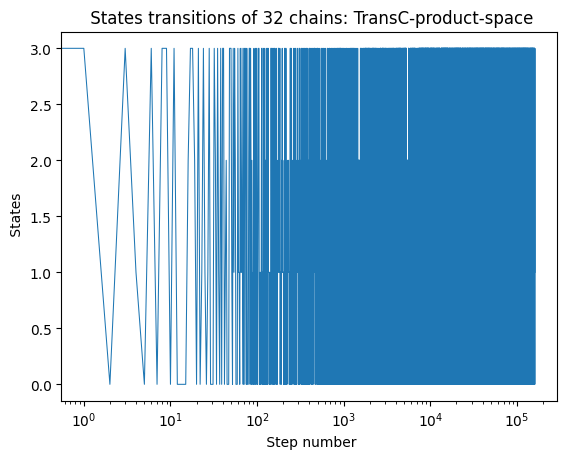

In [30]:
# plot chain states
if(plotting):
    # plot chains for each state and walker
    plt.semilogx(states_chain.reshape(np.shape(states_chain)[0],-1),lw=0.75)
    plt.xlabel(' Step number')
    plt.ylabel(' States')
    title = ' States transitions of '+str(nwalkers_ps)+' chains: '+key.alg
    plt.title(title)
    #plt.savefig('PS_chain_transistions.pdf')
    plt.show()

This plot shows the movement of each chain between states.

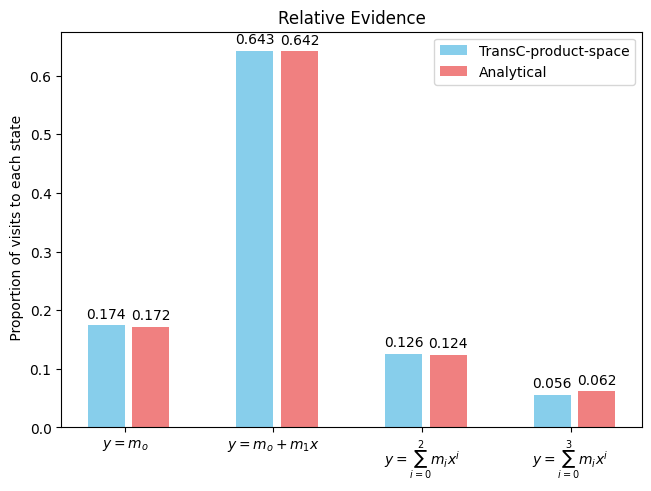

In [31]:
# Count visits to each state by Trans-D mcmc
if(plotting):
    h=np.zeros(key.nstates)
    h[list(Counter(states_chain.reshape(-1)).keys())] = list(Counter(states_chain.reshape(-1)).values())
    h/=np.sum(h)
    # plot histogram of frequency of visits to each state

    labels = [r'$y=m_o$', r'$y=m_o + m_1x$', r'$y = \sum_{i=0}^2 m_ix^i$', r'$y = \sum_{i=0}^3 m_ix^i$']
    x = np.arange(nstates)  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')
    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(h,3), width, label=key.alg,color='skyblue')
    ax.bar_label(rects, padding=3)
    multiplier += 1
    offset = width * multiplier+0.05
    rects = ax.bar(x + offset, np.round(counts,3), width, label='Analytical',color='lightcoral')
    ax.bar_label(rects, padding=3)
    multiplier += 1
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(' Proportion of visits to each state')
    ax.set_title('Relative Evidence')
    ax.set_xticks(x + width/2, labels)
    ax.legend(loc='upper right')
    #plt.savefig('PS_relative_evidences.pdf')
    plt.show()

 State;  1  in  2  dimensions
 State;  2  in  3  dimensions
 State;  3  in  4  dimensions


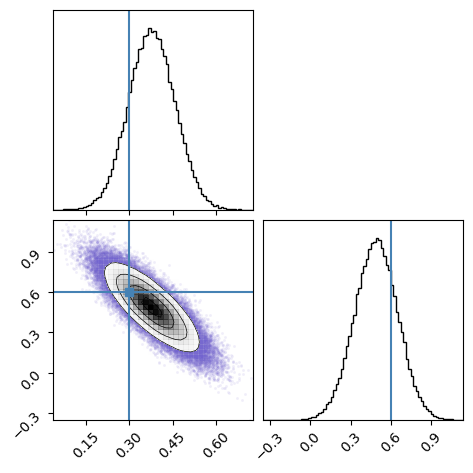

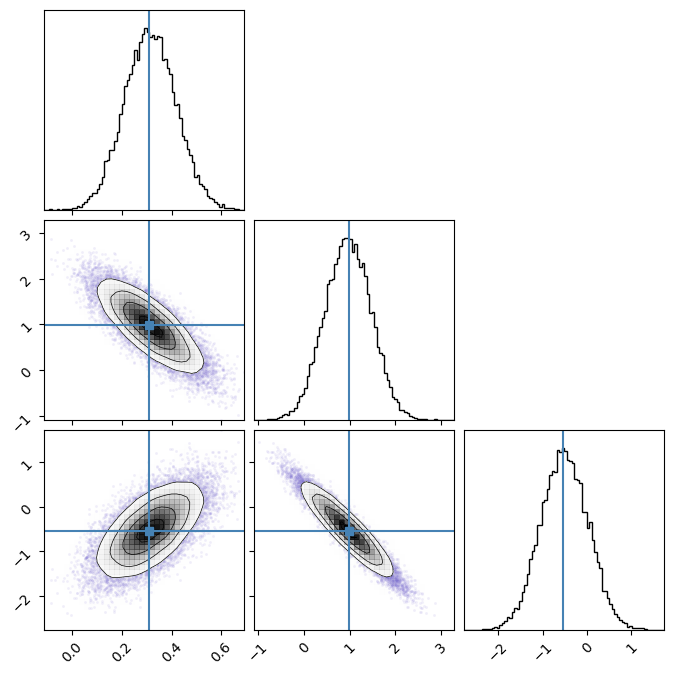

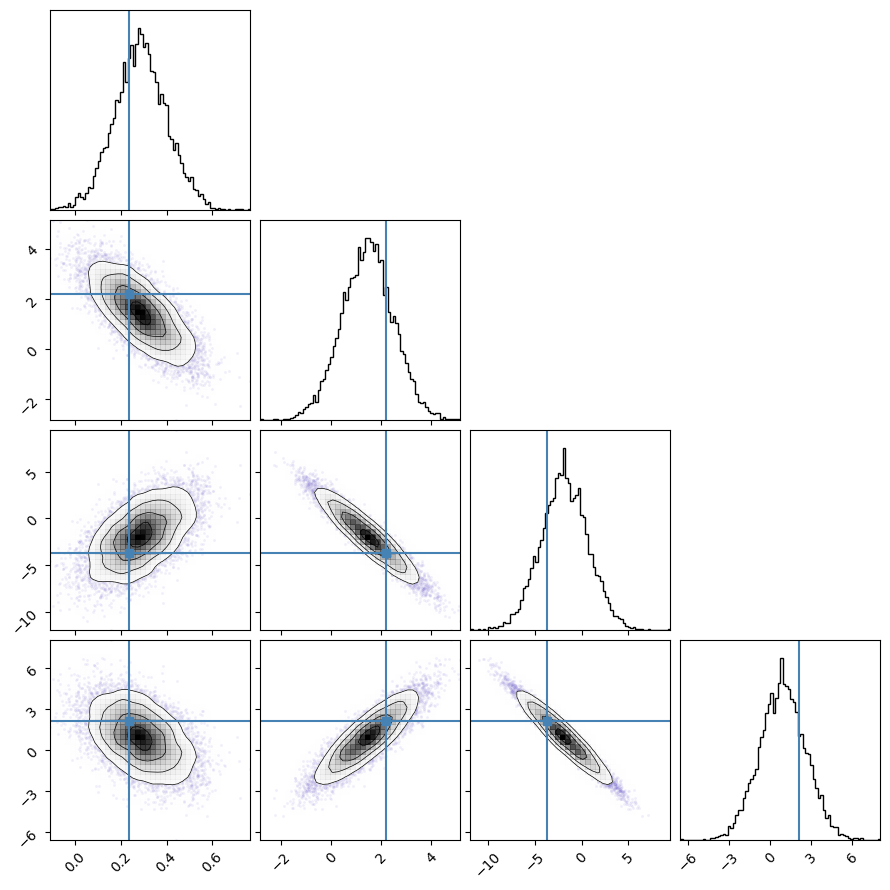

In [33]:
# corner plots to check sampling within each state
if(plotting):
    muplot = mls.copy()
    muplot[1] = mtrue
    # collect trans samples
    transc_ensemble,model_chain,states_chain = key.get_transc_samples(discard=0,thin=thin,flat=True,returnchains=True)
    contour_kwargs = {"linewidths" : 0.5}
    data_kwargs = {"color" : "slateblue"}
    for i in range(1,nstates):
        string = 'Order '+str(i)
        print(' State; ',i,' in ',ndims[i],' dimensions')
        fig = corner.corner(
            flatten_extend(transc_ensemble[i]).reshape(-1,ndims[i]), 
            truths=muplot[i],
            title=string,
            bins=40,hist_bin_factor=2,smooth=True,contour_kwargs=contour_kwargs,data_kwargs=data_kwargs
            );
        #fig.savefig('PS_corner_'+str(i)+'.pdf')

In [28]:
print(' Here is the Trans-C ensemble with\n {} samples in state 1\n {} samples in state 2\n {} samples in state 3\n'
      .format(len(transc_ensemble[0]),len(transc_ensemble[1]),len(transc_ensemble[2])),'\n',transc_ensemble)

 Here is the Trans-C ensemble with
 27898 samples in state 1
 102943 samples in state 2
 20165 samples in state 3
 
 [array([[0.58260642],
       [0.58047856],
       [0.57856538],
       ...,
       [0.47672377],
       [0.57967648],
       [0.55242427]], shape=(27898, 1)), array([[0.37328303, 0.48735298],
       [0.37893729, 0.48444519],
       [0.37595277, 0.48848556],
       ...,
       [0.30154508, 0.56751103],
       [0.3921673 , 0.47790177],
       [0.31350117, 0.63451029]], shape=(102943, 2)), array([[ 0.31159015,  0.95353827, -0.51944783],
       [ 0.32442183,  0.99687869, -0.52016134],
       [ 0.24937012,  1.00735826, -0.42373356],
       ...,
       [ 0.25633241,  1.29098179, -0.86900472],
       [ 0.36027363,  0.66695246, -0.13686635],
       [ 0.22991756,  1.02903127, -0.24637993]], shape=(20165, 3)), array([[ 0.28553574,  1.43915086, -1.83336078,  0.89620737],
       [ 0.28523002,  1.43947563, -1.83227887,  0.89618943],
       [ 0.2850743 ,  1.43937643, -1.83264682,  0.8

---------